# Part B

In [1]:
import numpy as np
import torch
import pyro
import pyro.distributions as pdist
import pyro.contrib.gp as gp
import matplotlib.pyplot as plt

In [2]:
def g(x):
    if torch.is_tensor(x):
        return -torch.pow(torch.sin(6*torch.pi*x), 2) + 6*torch.pow(x, 2) - 5*torch.pow(x, 4) + 3/2
    else:
        return -np.power(np.sin(6*np.pi*x), 2) + 6*np.power(x, 2) - 5*np.power(x, 4) + 3/2

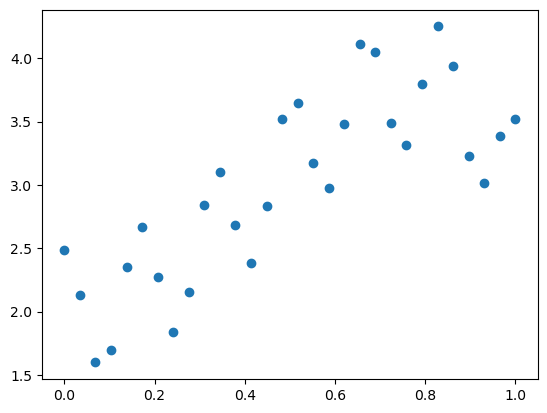

In [9]:
ell = 30 
pyro.util.set_rng_seed(0)
torch.manual_seed(0)

def generate_30_samples():
    x = torch.Tensor([(i-1)/(ell-1) for i in range(1, ell+1)]) 
    with pyro.plate("data", x.shape[0]): 
        eps = pyro.sample('eps', pdist.Normal(torch.ones(1), torch.ones(1)*0.01))
        y = g(x) + eps

    training, testing = torch.utils.data.random_split(x, [20, 10])
    X_train = x[training.indices]
    X_test = x[testing.indices]
    y_train = y[training.indices]
    y_test = y[testing.indices]

    plt.scatter(x,y)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = generate_30_samples()

In [8]:
def plot(
    X,
    y,
    plot_observed_data=False,
    plot_predictions=False,
    n_prior_samples=0,
    model=None,
    kernel=None,
    n_test=500,
    ax=None
):

    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    if plot_observed_data:
        ax.plot(X.numpy(), y.numpy(), "kx")
    if plot_predictions:
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        # compute predictive mean and variance
        with torch.no_grad():
            if type(model) == gp.models.VariationalSparseGP:
                mean, cov = model(Xtest, full_cov=True)
            else:
                mean, cov = model(Xtest, full_cov=True, noiseless=False)
        sd = cov.diag().sqrt()  # standard deviation at each input point x
        ax.plot(Xtest.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
        ax.fill_between(
            Xtest.numpy(),  # plot the two-sigma uncertainty about the mean
            (mean - 2.0 * sd).numpy(),
            (mean + 2.0 * sd).numpy(),
            color="C0",
            alpha=0.3,
        )
    if n_prior_samples > 0:  # plot samples from the GP prior
        Xtest = torch.linspace(-0.5, 5.5, n_test)  # test inputs
        noise = (
            model.noise
            if type(model) != gp.models.VariationalSparseGP
            else model.likelihood.variance
        )
        cov = kernel.forward(Xtest) + noise.expand(n_test).diag()
        samples = pdist.MultivariateNormal(
            torch.zeros(n_test), covariance_matrix=cov
        ).sample(sample_shape=(n_prior_samples,))
        ax.plot(Xtest.numpy(), samples.numpy().T, lw=2, alpha=0.4)

    ax.set_xlim(0, 1)


def plot_loss(loss):
    plt.plot(loss)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    
    
def loss_fn(model, X, y):
    # run the model forward on the data
    print(X)
    y_pred = model(X)
    # calculate the mse loss
    loss = torch.sum((y_pred - y) ** 2) / len(y_pred)
    # calculate the prior loss
    for param_name, param in model.named_parameters():
        if param_name == "noise":
            continue
        loss += torch.sum(param ** 2)
    return loss

NameError: name 'x' is not defined

## Part B.1

### Cosine Kernel

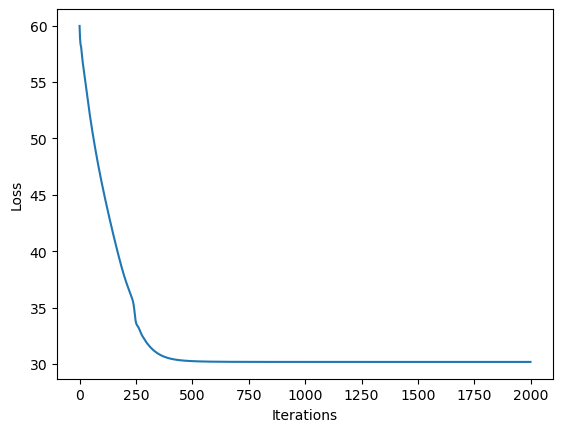

In [5]:
# Define the same model as before.
pyro.clear_param_store()
kernel = gp.kernels.Periodic(
    input_dim=1, 
    variance=torch.tensor(5.0), 
    lengthscale=torch.tensor(10.0),
    period=torch.tensor(1.0),
)
gpr = gp.models.GPRegression(X_train, y_train, kernel, noise=torch.tensor(1.0))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))
gpr.kernel.period = pyro.nn.PyroSample(pdist.LogNormal(0.0, 1.0))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
num_steps = 2000
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

plot_loss(losses)

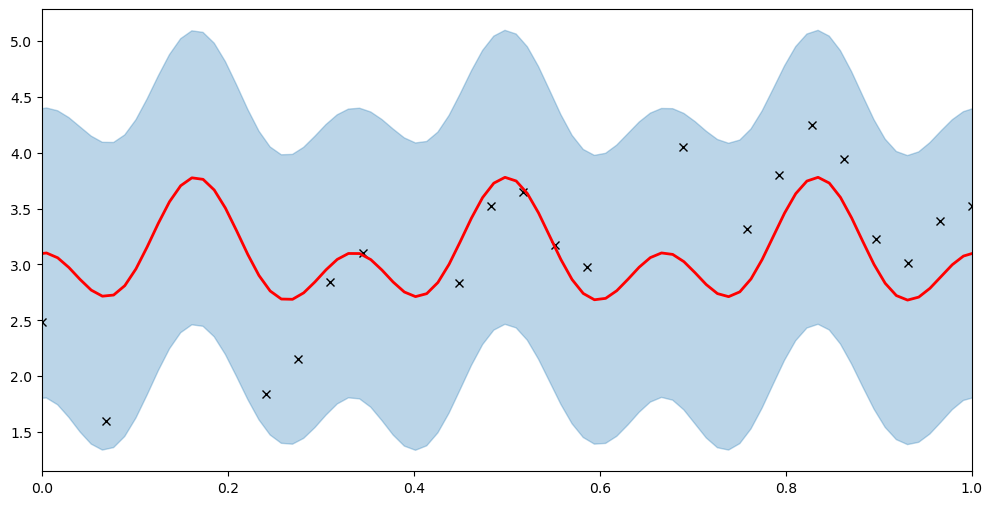

In [6]:
plot(X_train, y_train, model=gpr, plot_observed_data=True, plot_predictions=True)

In [7]:
gpr.set_mode("guide")
print("variance = {}".format(gpr.kernel.variance))
print("lengthscale = {}".format(gpr.kernel.lengthscale))


variance = 2.371837615966797
lengthscale = 1.630484938621521
